In [1]:
import os
import copy

import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm

from IPython.display import display

from utils.constants import *

In [2]:
def summarize_restarts(orig_df, groupby_cols=['source_state', 'target_state'], max_restarts=5):
    df = copy.deepcopy(orig_df)
    if 'iter' in df.columns:
        df = df[df.iter < max_restarts]
    else:
        df = df[df.seed < max_restarts]
    groups = df.groupby(groupby_cols).size().reset_index().rename(columns={0: 'count'})
    groups = groups.loc[groups['count'] > 0, :]
    rows = []
    for group in groups.values.tolist():
        group = group[:len(groupby_cols)]  # Isolate groupby
        query = []
        for i in range(len(group)):
            if isinstance(group[i], str):
                query.append(f"({groupby_cols[i]}.str.strip() == '{group[i]}')")
            else:
                query.append(f"({groupby_cols[i]} == {group[i]})")
        query = ' & '.join(query)
        df_i = df[df.eval(query)]
        row = group
        means = df_i[metric_cols].mean(0).values.tolist()
        stds = [0. if np.isnan(i) else i for i in df_i[metric_cols].std(0).values.tolist()]
        row += ['{:.3f} ({:.3f})'.format(mean, std) for mean, std in zip(means, stds)]
        row += [df_i.shape[0]]
        rows.append(row)
    cols = groupby_cols + metric_cols + ['num_restarts']
    out_df = pd.DataFrame(data=rows, columns=cols)
    return out_df

In [3]:
def print_df(df, metric_prefix='target'):
    pairs = list(set([tuple(i) for i in df[['source_state', 'target_state']].values.tolist()]))
    pairs = [('IL', 'IL')] + sorted([pair for pair in pairs if pair != ('IL', 'IL')])
    color_dict = {f'{metric_prefix}_acc': 'green', f'{metric_prefix}_auc': 'blue', f'{metric_prefix}_loss': 'purple'}
    df_color = df.style.apply(lambda x: ['background: {}'.format(color_dict[x.name]) if x.name in color_dict.keys() else '' for i in x])
    display(df_color)

In [4]:
def get_attr_val_from_dirname_combined(d):
    """Parses attributes from combined ERM experiment directory name."""
    def get_attr(s):
        """Returns the value associated with the attribute."""
        return s.split('-')[-1]

    split_dir = d.split('_')
    ret_dict = {}
    ret_dict['exp_dir'] = d
    ret_dict['backbone'] = split_dir[0]
    ret_dict['source_state'] = get_attr(split_dir[2])
    ret_dict['target_state'] = get_attr(split_dir[3])
    ret_dict['num_source'] = get_attr(split_dir[4])
    ret_dict['num_target'] = get_attr(split_dir[5])
    return ret_dict

def get_attr_val_from_dirname(d):
    """Parses attributes from experiment directory name."""
    def get_attr(s):
        """Returns the value associated with the attribute."""
        return s.split('-')[-1]

    split_dir = d.split('_')
    ret_dict = {}
    ret_dict['exp_dir'] = d
    ret_dict['backbone'] = split_dir[0]
    ret_dict['source_state'] = get_attr(split_dir[1])
    ret_dict['target_state'] = get_attr(split_dir[2])
    if split_dir[3].split('-')[0] == 'ft':
        ret_dict['fine_tune'] = '-'.join((split_dir[3].split('-'))[1:])
        ret_dict['num_source'] = get_attr(split_dir[4])
        ret_dict['num_target'] = get_attr(split_dir[5])
    else:
        ret_dict['num_source'] = get_attr(split_dir[3])
        ret_dict['num_target'] = get_attr(split_dir[4])
    return ret_dict

def get_src_tgt_metrics(results, src, tgt):
    """Returns a dictionary of source and target metrics."""
    return {
        'source_acc': results[f'{src}_acc'],
        'source_auc': results[f'{src}_auc'],
        'source_loss': results[f'{src}_loss'],
        'target_acc': results[f'{tgt}_acc'],
        'target_auc': results[f'{tgt}_auc'],
        'target_loss': results[f'{tgt}_loss'],
    }

# Combined ERM

In [28]:
res_dir = os.path.join(RESULTS_DIR, 'early_stop_auc', 'combined')

# Get results from child experimental directories
entries = []
incomplete = []
for d in tqdm(os.listdir(res_dir)):
    parsed_d = get_attr_val_from_dirname_combined(d)
    results_count = 0
    for f in os.listdir(os.path.join(res_dir, d)):
        if 'results' in f:
            results = json.load(open(os.path.join(res_dir, d, f), 'rb'))
            results.update(get_src_tgt_metrics(
                results, parsed_d['source_state'], parsed_d['target_state']))
            results.update(parsed_d)
            entries.append(results)
            results_count += 1
    # Check that all 5 iterations were completed
    if results_count != 5:
        incomplete.append(d)

  0%|          | 0/3 [00:00<?, ?it/s]

In [29]:
print('Directories with missing results:')
for d in incomplete:
    print('\t', d)

Directories with missing results:


In [30]:
state_metric_cols = ['IL_acc', 'IL_auc', 'IL_loss', 'CA_acc', 'CA_auc', 'CA_loss',
               'IN_acc', 'IN_auc', 'IN_loss', 'TX_acc', 'TX_auc', 'TX_loss']
metric_cols = ['source_acc', 'source_auc', 'source_loss', 'target_acc', 'target_auc', 'target_loss']
cols = ['backbone', 'approach', 'domain', 'train_state', 'test_state', 'iter', 'n_samples', 'block', 'bn',
        'source_state', 'target_state', 'fine_tune', 'num_source', 'num_target'] + state_metric_cols + metric_cols

df = pd.DataFrame.from_records(entries, columns=cols).drop(state_metric_cols, axis=1)
df = df.loc[(df['source_state'] != 'NC') & (df['target_state'] != 'NC')]

In [31]:
df['source_state'] = pd.Categorical(
    df['source_state'], 
    categories=['IL'] + sorted([state for state in df.source_state.unique() if state != 'IL']), 
    ordered=True
)
df['target_state'] = pd.Categorical(
    df['target_state'], 
    categories=['IL'] + sorted([state for state in df.target_state.unique() if state != 'IL']), 
    ordered=True
)

In [32]:
# Create a long-form DataFrame with pivoted metric entries
df_lf = df.copy()
df_lf.loc[:, 'metric'] = df_lf.apply(lambda x: ['accuracy', 'auroc', 'logloss'], axis=1)
df_lf.loc[:, 'source_value'] = df_lf.apply(lambda x: [x.source_acc, x.source_auc, x.source_loss], axis=1)
df_lf.loc[:, 'target_value'] = df_lf.apply(lambda x: [x.target_acc, x.target_auc, x.target_loss], axis=1)

df_lf = df_lf.explode(['metric', 'source_value', 'target_value']).drop(metric_cols, axis=1)

In [33]:
data = df.loc[(df['backbone'] == 'resnet152') & (df['approach'] == 'Concat_ERM')].drop_duplicates(ignore_index=True)
data = data.sort_values('target_state').reset_index(drop=True)

data_lf = df_lf.loc[(df_lf['backbone'] == 'resnet152') & (df_lf['approach'] == 'Concat_ERM')].drop_duplicates(ignore_index=True)
data_lf = data_lf.sort_values('target_state').reset_index(drop=True)

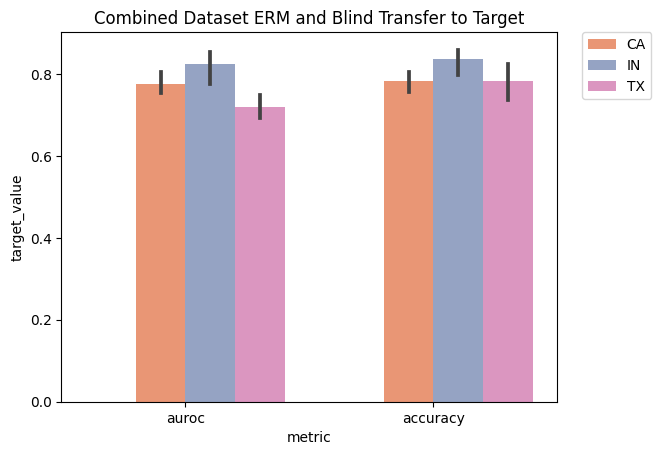

In [34]:
sns.barplot(data=data_lf.loc[(data_lf['metric'] != 'logloss')].drop_duplicates(ignore_index=True),
            x='metric', y='target_value', hue='target_state', hue_order=['', 'CA', 'IN', 'TX'], palette='Set2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.title('Combined Dataset ERM and Blind Transfer to Target');

In [35]:
print_df(summarize_restarts(data))

,source_state,target_state,source_acc,source_auc,source_loss,target_acc,target_auc,target_loss,num_restarts
0,IL,CA,0.866 (0.012),0.857 (0.013),0.815 (0.085),0.782 (0.034),0.776 (0.033),1.325 (0.184),5
1,IL,IN,0.862 (0.010),0.850 (0.011),0.943 (0.078),0.836 (0.044),0.824 (0.054),1.155 (0.408),5
2,IL,TX,0.869 (0.008),0.859 (0.012),0.832 (0.150),0.782 (0.058),0.719 (0.037),1.626 (0.579),5


# Parse Results Files

In [6]:
res_dir = os.path.join(RESULTS_DIR, 'early_stop_loss', 'resnet')

# Get results from child experimental directories
entries = []
incomplete = []
for d in tqdm(os.listdir(res_dir)):
    parsed_d = get_attr_val_from_dirname(d)
    results_count = 0
    for f in os.listdir(os.path.join(res_dir, d)):
        if 'results' in f:
            results = json.load(open(os.path.join(res_dir, d, f), 'rb'))
            results.update(get_src_tgt_metrics(
                results, parsed_d['source_state'], parsed_d['target_state']))
            results.update(parsed_d)
            entries.append(results)
            
            # Add additional entries for in-distribution performance
            if 'fine_tune' not in parsed_d.keys() and parsed_d['source_state'] == 'IL':
                idd_results = copy.deepcopy(results)
                idd_results['test_state'] = results['train_state']
                idd_results['source_state'] = results['train_state']
                idd_results['target_state'] = results['train_state']
                idd_results.update(get_src_tgt_metrics(
                    idd_results, idd_results['source_state'], idd_results['target_state']))
                entries.append(idd_results)
            
            results_count += 1
    # Check that all 5 iterations were completed
    if results_count != 5:
        incomplete.append(d)

  0%|          | 0/111 [00:00<?, ?it/s]

In [7]:
res_dirs = [os.path.join(RESULTS_DIR, 'early_stop_loss', d) for d in [
    'film_block-none_bn-0_none',
    'film_block-4_bn-0123_all'
]]

# Get FiLM results, parsing parent directory
incomplete = []
for parent_dir in tqdm(res_dirs):
    for d in os.listdir(parent_dir):
        parsed_d = get_attr_val_from_dirname(d)
        parsed_d['block'] = parent_dir.split('/')[-1].split('_')[1].split('-')[-1]
        parsed_d['bn'] = parent_dir.split('/')[-1].split('_')[2].split('-')[-1]
        parsed_d['density'] = parent_dir.split('/')[-1].split('_')[3]
        results_count = 0
        for f in os.listdir(os.path.join(parent_dir, d)):
            if 'results' in f:
                results = json.load(open(os.path.join(parent_dir, d, f), 'rb'))
                results.update(get_src_tgt_metrics(
                    results, parsed_d['source_state'], parsed_d['target_state']))
                results.update(parsed_d)
                entries.append(results)

                # Add additional entries for in-distribution performance
                if 'fine_tune' not in parsed_d.keys() and parsed_d['source_state'] == 'IL':
                    idd_results = copy.deepcopy(results)
                    idd_results['test_state'] = results['train_state']
                    idd_results['source_state'] = results['train_state']
                    idd_results['target_state'] = results['train_state']
                    idd_results.update(get_src_tgt_metrics(
                        idd_results, idd_results['source_state'], idd_results['target_state']))
                    entries.append(idd_results)

                results_count += 1
        # Check that all 5 iterations were completed
        if results_count != 5:
            incomplete.append(d)

  0%|          | 0/2 [00:00<?, ?it/s]

In [8]:
print('Directories with missing results:')
for d in incomplete:
    print('\t', d)

Directories with missing results:


In [9]:
state_metric_cols = ['IL_acc', 'IL_auc', 'IL_loss', 'CA_acc', 'CA_auc', 'CA_loss',
               'IN_acc', 'IN_auc', 'IN_loss', 'TX_acc', 'TX_auc', 'TX_loss']
metric_cols = ['source_acc', 'source_auc', 'source_loss', 'target_acc', 'target_auc', 'target_loss']
cols = ['backbone', 'approach', 'domain', 'train_state', 'test_state', 'seed', 'n_samples', 'block', 'bn', 'density',
        'source_state', 'target_state', 'fine_tune', 'num_source', 'num_target'] + state_metric_cols + metric_cols

df = pd.DataFrame.from_records(entries, columns=cols).drop(state_metric_cols, axis=1)
df = df.loc[(df['train_state'] != 'NC') & (df['test_state'] != 'NC')]

In [10]:
df['train_state'] = pd.Categorical(
    df['train_state'], 
    categories=['IL'] + sorted([state for state in df.train_state.unique() if state != 'IL']), 
    ordered=True
)
df['test_state'] = pd.Categorical(
    df['test_state'], 
    categories=['IL'] + sorted([state for state in df.test_state.unique() if state != 'IL']), 
    ordered=True
)
df['source_state'] = pd.Categorical(
    df['source_state'], 
    categories=['IL'] + sorted([state for state in df.source_state.unique() if state != 'IL']), 
    ordered=True
)
df['target_state'] = pd.Categorical(
    df['target_state'], 
    categories=['IL'] + sorted([state for state in df.target_state.unique() if state != 'IL']), 
    ordered=True
)

In [11]:
# Create a long-form DataFrame with pivoted metric entries
df_lf = df.copy()
df_lf.loc[:, 'metric'] = df_lf.apply(lambda x: ['accuracy', 'auroc', 'logloss'], axis=1)
df_lf.loc[:, 'source_value'] = df_lf.apply(lambda x: [x.source_acc, x.source_auc, x.source_loss], axis=1)
df_lf.loc[:, 'target_value'] = df_lf.apply(lambda x: [x.target_acc, x.target_auc, x.target_loss], axis=1)

df_lf = df_lf.explode(['metric', 'source_value', 'target_value']).drop(metric_cols, axis=1)

# ResNet Source ERM

In [12]:
data = df.loc[(df['backbone'] == 'resnet152') & (df['approach'] == 'Source_ERM_ResNet')].drop_duplicates(ignore_index=True)
data = data.sort_values('target_state').reset_index(drop=True)

data_lf = df_lf.loc[(df_lf['backbone'] == 'resnet152') & (df_lf['approach'] == 'Source_ERM_ResNet')].drop_duplicates(ignore_index=True)
data_lf = data_lf.sort_values('target_state').reset_index(drop=True)

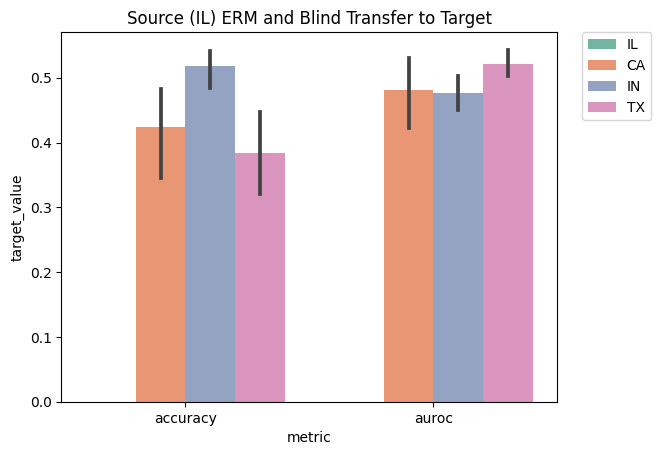

In [13]:
sns.barplot(data=data_lf.loc[(data_lf['metric'] != 'logloss')].drop_duplicates(ignore_index=True),
            x='metric', y='target_value', hue='target_state', hue_order=['IL', 'CA', 'IN', 'TX'], palette='Set2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.title('Source (IL) ERM and Blind Transfer to Target');

In [14]:
source_erm_resnet = summarize_restarts(data)

In [15]:
print_df(source_erm_resnet)

,source_state,target_state,source_acc,source_auc,source_loss,target_acc,target_auc,target_loss,num_restarts
0,IL,CA,0.763 (0.038),0.736 (0.045),0.540 (0.040),0.423 (0.090),0.481 (0.072),1.377 (0.343),5
1,IL,IN,0.763 (0.038),0.736 (0.045),0.540 (0.040),0.518 (0.037),0.476 (0.033),1.081 (0.249),5
2,IL,TX,0.763 (0.038),0.736 (0.045),0.540 (0.040),0.384 (0.082),0.522 (0.025),1.332 (0.240),5


# Fine-Tune ResNet

In [16]:
data = df.loc[(df['backbone'] == 'resnet152') & (df['approach'] == 'Fine_Tune_ResNet')].drop_duplicates(ignore_index=True)
data = data.sort_values('target_state').reset_index(drop=True)
data = data.dropna(subset=['seed'], axis=0)

data_lf = df_lf.loc[(df_lf['backbone'] == 'resnet152') & (df_lf['approach'] == 'Fine_Tune_ResNet')].drop_duplicates(ignore_index=True)
data_lf = data_lf.sort_values('target_state').reset_index(drop=True)

# Concatenate source ERM entries
source_erm = df.loc[(df['backbone'] == 'resnet152') & (df['approach'] == 'Source_ERM_ResNet')].drop_duplicates(ignore_index=True)
source_erm = source_erm.sort_values('target_state').reset_index(drop=True)
source_erm.loc[:, 'fine_tune'] = 'all'
source_erm.loc[:, 'n_samples'] = 0
data = pd.concat([data, source_erm], axis=0)

source_erm_lf = df_lf.loc[(df_lf['backbone'] == 'resnet152') & (df_lf['approach'] == 'Source_ERM_ResNet')].drop_duplicates(ignore_index=True)
source_erm_lf = source_erm_lf.sort_values('target_state').reset_index(drop=True)
source_erm_lf.loc[:, 'fine_tune'] = 'all'
source_erm_lf.loc[:, 'n_samples'] = 0
data_lf = pd.concat([data_lf, source_erm_lf], axis=0)

In [17]:
data_lf.fine_tune.unique()

array(['block1', 'bn0-clf', 'block3', 'block4', 'block2', 'clf', 'all'],
      dtype=object)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

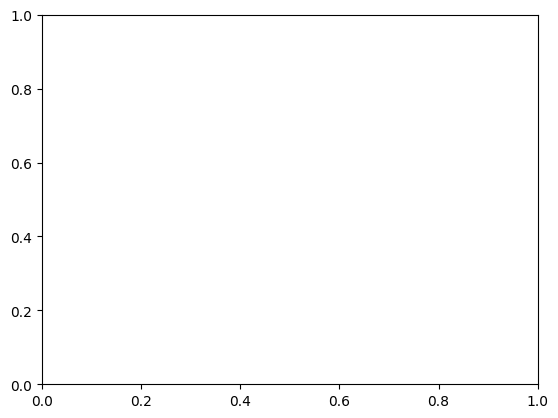

In [388]:
sns.barplot(data=data_lf.loc[(data_lf['metric'] != 'logloss') & (data_lf['n_samples'] == -1) & (data_lf['fine_tune'] == 'all')].drop_duplicates(ignore_index=True),
            x='metric', y='target_value', hue='target_state', hue_order=['', 'CA', 'IN', 'TX'], palette='Set2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.title('Source (IL) ERM + Fine-Tuning all parameters w/ all labeled examples from Target');

In [389]:
print_df(summarize_restarts(data.loc[(data['n_samples'] == -1) & (data['fine_tune'] == 'all')]))

,source_state,target_state,source_acc,source_auc,source_loss,target_acc,target_auc,target_loss,num_restarts


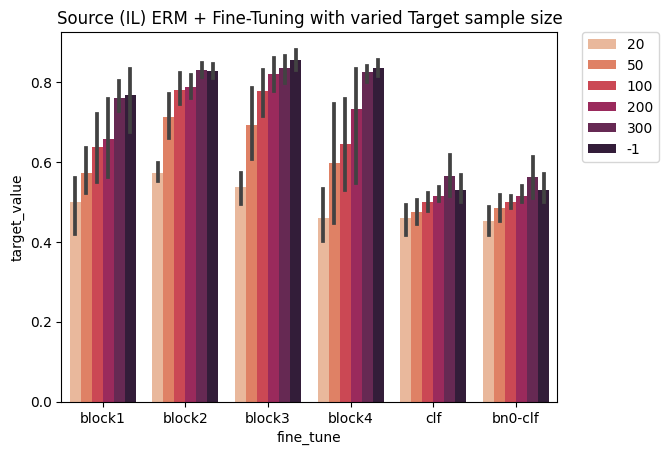

In [18]:
sns.barplot(data=data_lf.loc[(data_lf['metric'] == 'auroc') & (data_lf['target_state'] == 'CA')].drop_duplicates(ignore_index=True),
            x='fine_tune', y='target_value', hue='n_samples',
            order=['block1', 'block2', 'block3', 'block4', 'clf', 'bn0-clf'],
            hue_order=[20, 50, 100, 200, 300, -1], palette='rocket_r')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.title('Source (IL) ERM + Fine-Tuning with varied Target sample size');

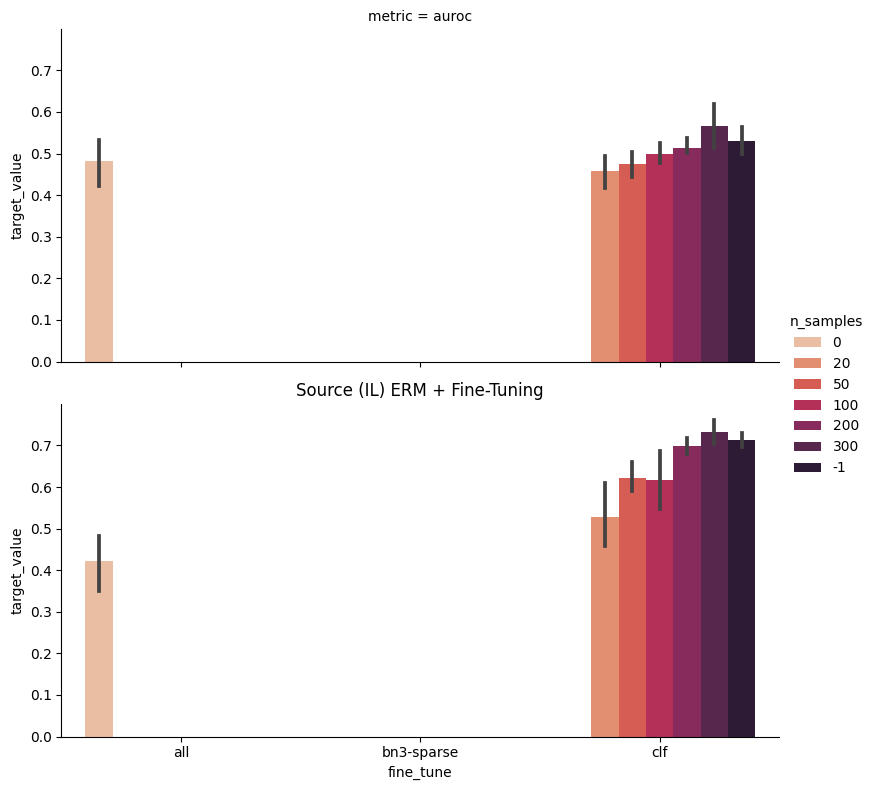

In [367]:
sns.catplot(data=data_lf.loc[(data_lf['metric'] != 'logloss') & (data_lf['target_state'] == 'CA')].drop_duplicates(ignore_index=True),
            x='fine_tune', order=['all', 'bn3-sparse', 'clf'],
            y='target_value', hue='n_samples', hue_order=[0, 20, 50, 100, 200, 300, -1], 
            row='metric', kind='bar', palette='rocket_r',
            height=4, aspect=2)
plt.title('Source (IL) ERM + Fine-Tuning');

In [118]:
print_df(summarize_restarts(data.loc[data['target_state'] == 'CA'], groupby_cols=['source_state', 'target_state', 'fine_tune', 'n_samples']))

,source_state,target_state,fine_tune,n_samples,source_acc,source_auc,source_loss,target_acc,target_auc,target_loss,num_restarts
0,IL,CA,all,0,0.869 (0.014),0.858 (0.017),0.860 (0.109),0.412 (0.034),0.434 (0.042),5.115 (0.556),5
1,IL,CA,block1,-1,0.833 (0.024),0.798 (0.033),1.499 (0.491),0.512 (0.036),0.605 (0.029),5.031 (1.253),5
2,IL,CA,block1,20,0.868 (0.016),0.853 (0.018),0.902 (0.097),0.411 (0.026),0.451 (0.029),5.588 (0.925),5
3,IL,CA,block1,50,0.869 (0.015),0.857 (0.018),0.881 (0.099),0.421 (0.021),0.445 (0.028),5.112 (0.599),5
4,IL,CA,block1,100,0.868 (0.014),0.851 (0.015),0.933 (0.125),0.418 (0.017),0.463 (0.019),5.467 (0.826),5
5,IL,CA,block1,200,0.869 (0.014),0.851 (0.015),0.948 (0.153),0.436 (0.017),0.487 (0.028),5.495 (0.857),5
6,IL,CA,block1,300,0.854 (0.020),0.829 (0.025),1.115 (0.166),0.496 (0.048),0.564 (0.067),4.755 (1.188),5
7,IL,CA,block2,-1,0.824 (0.009),0.805 (0.003),1.255 (0.166),0.725 (0.039),0.754 (0.049),1.970 (0.169),5
8,IL,CA,block2,20,0.867 (0.014),0.856 (0.017),0.882 (0.107),0.430 (0.020),0.457 (0.041),5.029 (0.572),5
9,IL,CA,block2,50,0.863 (0.015),0.845 (0.021),0.895 (0.084),0.450 (0.024),0.494 (0.041),4.667 (0.665),5


# ResNet Target ERM

In [228]:
data = df.loc[(df['backbone'] == 'resnet152') & (df['approach'] == 'Target_ERM_ResNet')].drop_duplicates(ignore_index=True)
data = data.sort_values('target_state').reset_index(drop=True)

data_lf = df_lf.loc[(df_lf['backbone'] == 'resnet152') & (df_lf['approach'] == 'Target_ERM_ResNet')].drop_duplicates(ignore_index=True)
data_lf = data_lf.sort_values('target_state').reset_index(drop=True)

In [ ]:
sns.barplot(data=data_lf.loc[(data_lf['metric'] != 'logloss')].drop_duplicates(ignore_index=True),
            x='metric', y='source_value', hue='train_state', hue_order=['', 'CA', 'IN', 'TX'], palette='Set2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.title('Target ERM');

In [205]:
target_erm_resnet = summarize_restarts(data)

In [206]:
print_df(target_erm_resnet, metric_prefix='source')

,source_state,target_state,source_acc,source_auc,source_loss,target_acc,target_auc,target_loss,num_restarts
0,CA,IL,0.895 (0.023),0.861 (0.016),0.324 (0.054),0.560 (0.025),0.509 (0.009),1.954 (0.863),5
1,IN,IL,0.814 (0.086),0.812 (0.065),0.448 (0.211),0.531 (0.034),0.509 (0.012),1.214 (0.133),5
2,TX,IL,0.861 (0.053),0.767 (0.016),1.154 (1.202),0.562 (0.025),0.512 (0.017),4.790 (6.204),5


# FiLM Source ERM

In [19]:
data = df.loc[(df['backbone'] == 'resnet152') & (df['approach'] == 'Source_ERM_FiLM') & (df['block'] == 'none') & (df['bn'] == '0') & (df['density'] == 'none')].drop_duplicates(ignore_index=True)
data = data.sort_values('target_state').reset_index(drop=True)

data_lf = df_lf.loc[(df_lf['backbone'] == 'resnet152') & (df_lf['approach'] == 'Source_ERM_FiLM') & (df['block'] == 'none') & (df['bn'] == '0') & (df['density'] == 'none')].drop_duplicates(ignore_index=True)
data_lf = data_lf.sort_values('target_state').reset_index(drop=True)

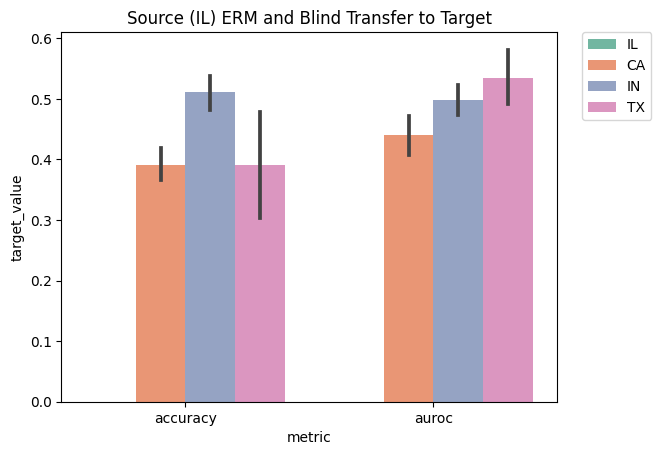

In [20]:
sns.barplot(data=data_lf.loc[(data_lf['metric'] != 'logloss')].drop_duplicates(ignore_index=True),
            x='metric', y='target_value', hue='target_state', hue_order=['IL', 'CA', 'IN', 'TX'], palette='Set2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.title('Source (IL) ERM and Blind Transfer to Target');

In [21]:
print_df(summarize_restarts(data))

,source_state,target_state,source_acc,source_auc,source_loss,target_acc,target_auc,target_loss,num_restarts
0,IL,CA,0.765 (0.056),0.746 (0.065),0.541 (0.044),0.391 (0.035),0.440 (0.042),1.631 (0.475),5
1,IL,IN,0.765 (0.056),0.746 (0.065),0.541 (0.044),0.511 (0.038),0.498 (0.033),1.236 (0.293),5
2,IL,TX,0.765 (0.056),0.746 (0.065),0.541 (0.044),0.390 (0.114),0.535 (0.060),1.415 (0.378),5


In [22]:
data_lf = df_lf.loc[(df_lf['backbone'] == 'resnet152') & (df_lf['approach'] == 'Source_ERM_FiLM') & (df['block'] == 'none') & (df['bn'] == '0') & (df['density'] == 'none')].drop_duplicates(ignore_index=True)
data_lf = pd.concat([data_lf, df_lf.loc[(df_lf['backbone'] == 'resnet152') & (df_lf['approach'] == 'Source_ERM_ResNet')]]).drop_duplicates(ignore_index=True)
data_lf = data_lf.sort_values('target_state').reset_index(drop=True)

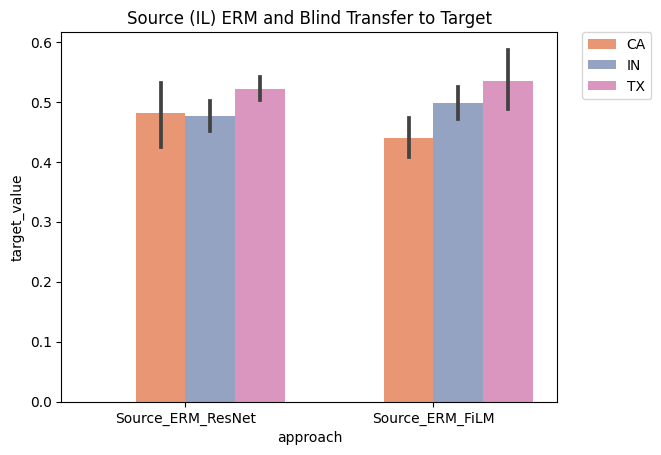

In [23]:
sns.barplot(data=data_lf.loc[(data_lf['metric'] == 'auroc')].drop_duplicates(ignore_index=True),
            x='approach', y='target_value', hue='target_state', hue_order=['', 'CA', 'IN', 'TX'], palette='Set2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.title('Source (IL) ERM and Blind Transfer to Target');

# Fine-Tune FiLM

In [32]:
data = df.loc[(df['backbone'] == 'resnet152') & (df['approach'] == 'Fine_Tune_FiLM') & (df['block'] == '4') & (df['bn'] == '0123') & (df['density'] == 'all')].drop_duplicates(ignore_index=True)
data = data.sort_values('target_state').reset_index(drop=True)

data_lf = df_lf.loc[(df_lf['backbone'] == 'resnet152') & (df_lf['approach'] == 'Fine_Tune_FiLM') & (df_lf['block'] == '4') & (df_lf['bn'] == '0123') & (df_lf['density'] == 'all')].drop_duplicates(ignore_index=True)
data_lf = data_lf.sort_values('target_state').reset_index(drop=True)

# Concatenate source ERM entries
source_erm = df.loc[(df['backbone'] == 'resnet152') & (df['approach'] == 'Source_ERM_FiLM') & (df['block'] == '4') & (df['bn'] == '0123') & (df['density'] == 'all')].drop_duplicates(ignore_index=True)
source_erm = source_erm.sort_values('target_state').reset_index(drop=True)
source_erm.loc[:, 'fine_tune'] = 'all'
source_erm.loc[:, 'n_samples'] = 0
data = pd.concat([data, source_erm], axis=0)

source_erm_lf = df_lf.loc[(df_lf['backbone'] == 'resnet152') & (df_lf['approach'] == 'Source_ERM_FiLM') & (df_lf['block'] == '4') & (df_lf['bn'] == '0123') & (df_lf['density'] == 'all')].drop_duplicates(ignore_index=True)
source_erm_lf = source_erm_lf.sort_values('target_state').reset_index(drop=True)
source_erm_lf.loc[:, 'fine_tune'] = 'all'
source_erm_lf.loc[:, 'n_samples'] = 0
data_lf = pd.concat([data_lf, source_erm_lf], axis=0)

In [33]:
temp = df.loc[(df['backbone'] == 'resnet152') & (df['approach'] == 'Fine_Tune_ResNet')].drop_duplicates(ignore_index=True)
temp = temp.sort_values('target_state').reset_index(drop=True)

temp_lf = df_lf.loc[(df_lf['backbone'] == 'resnet152') & (df_lf['approach'] == 'Fine_Tune_ResNet')].drop_duplicates(ignore_index=True)
temp_lf = temp_lf.sort_values('target_state').reset_index(drop=True)

# Concatenate source ERM entries
source_erm = df.loc[(df['backbone'] == 'resnet152') & (df['approach'] == 'Source_ERM_ResNet')].drop_duplicates(ignore_index=True)
source_erm = source_erm.sort_values('target_state').reset_index(drop=True)
source_erm.loc[:, 'fine_tune'] = 'all'
source_erm.loc[:, 'n_samples'] = 0
temp = pd.concat([temp, source_erm], axis=0)

source_erm_lf = df_lf.loc[(df_lf['backbone'] == 'resnet152') & (df_lf['approach'] == 'Source_ERM_ResNet')].drop_duplicates(ignore_index=True)
source_erm_lf = source_erm_lf.sort_values('target_state').reset_index(drop=True)
source_erm_lf.loc[:, 'fine_tune'] = 'all'
source_erm_lf.loc[:, 'n_samples'] = 0
temp_lf = pd.concat([temp_lf, source_erm_lf], axis=0)

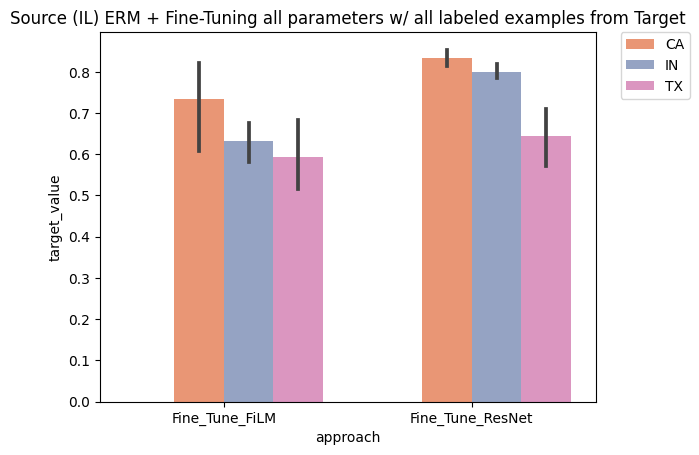

In [34]:
sns.barplot(data=pd.concat([
    data_lf.loc[(data_lf['metric'] == 'auroc') & ((data_lf['n_samples'] == -1)) & (data_lf['fine_tune'] == 'block4')].drop_duplicates(ignore_index=True),
    temp_lf.loc[(temp_lf['metric'] == 'auroc') & ((temp_lf['n_samples'] == -1)) & (temp_lf['fine_tune'] == 'block4')].drop_duplicates(ignore_index=True),
]),
            x='approach', y='target_value', hue='target_state', hue_order=['', 'CA', 'IN', 'TX'], palette='Set2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.title('Source (IL) ERM + Fine-Tuning all parameters w/ all labeled examples from Target');

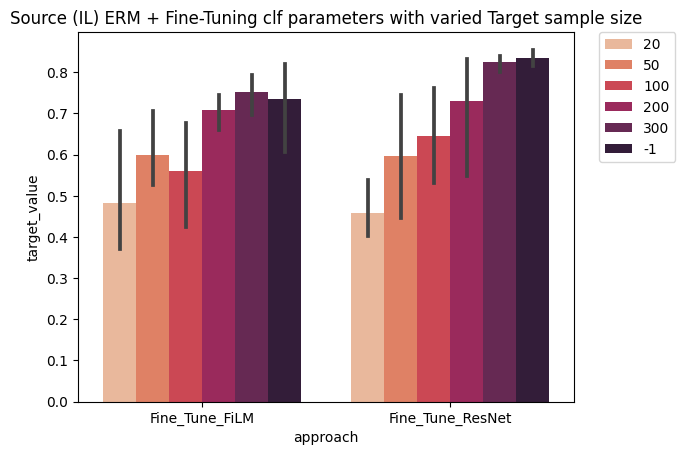

In [35]:
sns.barplot(data=pd.concat([
    data_lf.loc[(data_lf['metric'] == 'auroc') & (data_lf['n_samples'] != 0) & (data_lf['target_state'] == 'CA') & (data_lf['fine_tune'] == 'block4')].drop_duplicates(ignore_index=True),
    temp_lf.loc[(temp_lf['metric'] == 'auroc') & (temp_lf['n_samples'] != 0) & (temp_lf['target_state'] == 'CA') & (temp_lf['fine_tune'] == 'block4')].drop_duplicates(ignore_index=True),
]),
            x='approach', y='target_value', hue='n_samples', hue_order=[20, 50, 100, 200, 300, -1], palette='rocket_r')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.title('Source (IL) ERM + Fine-Tuning clf parameters with varied Target sample size');

In [36]:
data = df.loc[(df['backbone'] == 'resnet152') & (df['approach'] == 'Fine_Tune_FiLM') & (df['block'].isin(['1', '2', '3', '4', '1234'])) & (df['bn'] == '3')].drop_duplicates(ignore_index=True)
data = data.sort_values('target_state').reset_index(drop=True)

data_lf = df_lf.loc[(df_lf['backbone'] == 'resnet152') & (df_lf['approach'] == 'Fine_Tune_FiLM') & (df['block'].isin(['1', '2', '3', '4', '1234'])) & (df_lf['bn'] == '3')].drop_duplicates(ignore_index=True)
data_lf = data_lf.sort_values('target_state').reset_index(drop=True)

In [29]:
sns.catplot(data=data_lf.loc[(data_lf['metric'] != 'logloss') & (data_lf['target_state'] == 'CA')].drop_duplicates(ignore_index=True),
            x='fine_tune', order=['all', 'bn3-sparse', 'clf'],
            y='target_value', hue='n_samples', hue_order=[20, 50, 100, 200, 300, -1], 
            row='metric', kind='bar', palette='rocket_r',
            height=4, aspect=2)
plt.title('Source (IL) ERM + Fine-Tuning');

ValueError: Number of rows must be a positive integer, not 0

<Figure size 800x0 with 0 Axes>

In [30]:
print_df(summarize_restarts(data.loc[data['target_state'] == 'CA'], groupby_cols=['source_state', 'target_state', 'fine_tune', 'n_samples']))

,source_state,target_state,fine_tune,n_samples,source_acc,source_auc,source_loss,target_acc,target_auc,target_loss,num_restarts


# FiLM Target ERM

In [31]:
data = df.loc[(df['backbone'] == 'resnet152') & (df['approach'] == 'Target_ERM_FiLM') & (df['block'] == 'none') & (df['bn'] == '0') & (df['density'] == 'none')].drop_duplicates(ignore_index=True)
data = data.sort_values('target_state').reset_index(drop=True)

data_lf = df_lf.loc[(df_lf['backbone'] == 'resnet152') & (df_lf['approach'] == 'Target_ERM_FiLM') & (df_lf['block'] == 'none') & (df_lf['bn'] == '0') & (df_lf['density'] == 'none')].drop_duplicates(ignore_index=True)
data_lf = data_lf.sort_values('target_state').reset_index(drop=True)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

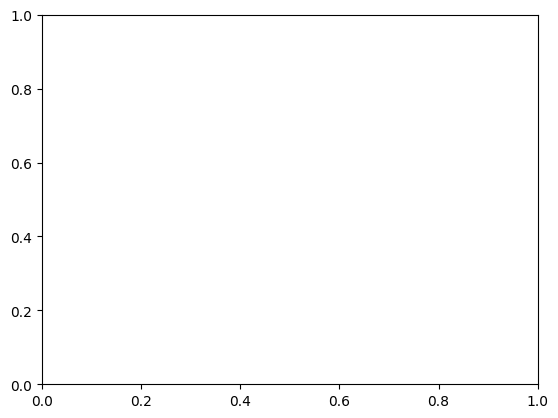

In [256]:
sns.barplot(data=data_lf.loc[(data_lf['metric'] != 'logloss')].drop_duplicates(ignore_index=True),
            x='metric', y='source_value', hue='train_state', hue_order=['', 'CA', 'IN', 'TX'], palette='Set2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.title('Target ERM');

In [300]:
print_df(summarize_restarts(data), metric_prefix='source')

,source_state,target_state,source_acc,source_auc,source_loss,target_acc,target_auc,target_loss,num_restarts
0,CA,IL,0.896 (0.016),0.863 (0.015),0.335 (0.034),0.555 (0.025),0.499 (0.007),1.383 (0.280),5
1,IN,IL,0.893 (0.011),0.884 (0.016),0.279 (0.042),0.536 (0.019),0.515 (0.010),1.405 (0.266),5
2,TX,IL,0.832 (0.073),0.735 (0.052),0.972 (0.403),0.534 (0.023),0.501 (0.005),3.247 (1.591),5


# Table: In/Out-of-distribution performance metrics

In [156]:
def in_out_metrics(source_df, target_df):
    all_df = pd.concat([source_df, target_df], axis=0)
    
    ind = pd.DataFrame()
    for source_state in all_df.source_state.unique():
        state_df = all_df[all_df.source_state == source_state].loc[
            :, ['source_state', 'source_acc', 'source_auc', 'source_loss']
        ].drop_duplicates()
        ind = pd.concat([ind, state_df], axis=0)
    ind.rename({
        'source_state': 'State',
        'source_acc': 'Accuracy',
        'source_auc': 'AUC ROC',
        'source_loss': 'Log-Loss',
    }, axis=1, inplace=True)
    ind.loc[:, 'Evaluation'] = 'In-distrbution'
    
    ood = pd.DataFrame()
    for target_state in all_df.target_state.unique():
        state_df = all_df[all_df.target_state == target_state].loc[
            :, ['target_state', 'target_acc', 'target_auc', 'target_loss']
        ]
        state_df = state_df[state_df.target_state != 'IL']
        ood = pd.concat([ood, state_df], axis=0)
    ood.rename({
        'target_state': 'State',
        'target_acc': 'Accuracy',
        'target_auc': 'AUC ROC',
        'target_loss': 'Log-Loss',
    }, axis=1, inplace=True)
    ood.loc[:, 'Evaluation'] = 'Out-of-distribution'
    
    result = pd.concat([ind, ood], axis=0).reset_index(drop=True)
    result = result.melt(id_vars=['Evaluation', 'State'],
                         value_vars=['Accuracy', 'AUC ROC', 'Log-Loss'],
                         var_name='Metric', value_name='Value')
    result = result.pivot(index=['Evaluation', 'Metric'], columns='State')
    result = result.reindex(['IL', 'CA', 'IN', 'TX'], axis=1, level=1)
    result = result.reindex(['Accuracy', 'AUC ROC', 'Log-Loss'], axis=0, level=1)
    
    return result

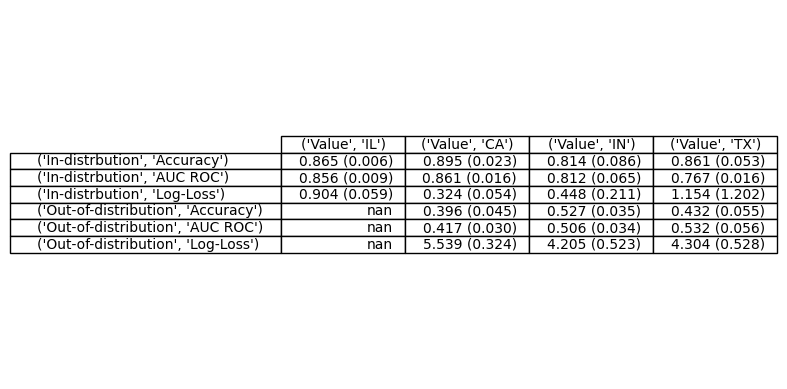

In [172]:
ax = plt.subplot(111, frame_on=False) # no visible frame
ax.xaxis.set_visible(False) # hide the x axis
ax.yaxis.set_visible(False) # hide the y axis
pd.plotting.table(ax, in_out_metrics(source_erm_resnet, target_erm_resnet), loc='center');

In [173]:
in_out_metrics(source_erm_resnet, target_erm_resnet)

Value                                \
State                                    IL             CA             IN   
Evaluation          Metric                                                  
In-distrbution      Accuracy  0.865 (0.006)  0.895 (0.023)  0.814 (0.086)   
                    AUC ROC   0.856 (0.009)  0.861 (0.016)  0.812 (0.065)   
                    Log-Loss  0.904 (0.059)  0.324 (0.054)  0.448 (0.211)   
Out-of-distribution Accuracy            NaN  0.396 (0.045)  0.527 (0.035)   
                    AUC ROC             NaN  0.417 (0.030)  0.506 (0.034)   
                    Log-Loss            NaN  5.539 (0.324)  4.205 (0.523)   

                                             
State                                    TX  
Evaluation          Metric                   
In-distrbution      Accuracy  0.861 (0.053)  
                    AUC ROC   0.767 (0.016)  
                    Log-Loss  1.154 (1.202)  
Out-of-distribution Accuracy  0.432 (0.055)  
                    AUC ROC   0.532 (0.056)  
                    Log-Loss  4.304 (0.528)

In [152]:
treat_dir = os.path.join(RESULTS_DIR, 'new_results', 'early_stop_auc', 'film_block-none_bn-0_none', 'resnet152_source-IL_target-CA_ft-all_ns-all_nt-0')
treat_results = json.load(open(os.path.join(treat_dir, 'source_stats_CA_n-all_0.json'), 'rb'))
control_dir = os.path.join(RESULTS_DIR, 'new_results', 'early_stop_auc', 'resnet', 'resnet152_source-IL_target-CA_ft-all_ns-all_nt-0')
control_results = json.load(open(os.path.join(control_dir, 'source_stats_CA_n-all_0.json'), 'rb'))

In [153]:
treat_results.keys()

dict_keys(['train_grad_norm', 'valid_grad_norm', 'test_grad_norm', 'param_fro_norm', 'param_l2_norm'])

In [154]:
control_results.keys()

dict_keys(['train_grad_norm', 'valid_grad_norm', 'test_grad_norm', 'param_fro_norm', 'param_l2_norm'])

In [165]:
treat_results['test_grad_norm']['module.linear.bias']

0.021858976654974476

In [166]:
control_results['test_grad_norm']['module.linear.bias']

0.018037946362580572

In [171]:
treat_clf_grad_norm = []
control_clf_grad_norm = []
for i in range(5):
    treat_results = json.load(open(os.path.join(treat_dir, f'source_stats_CA_n-all_{i}.json'), 'rb'))
    control_results = json.load(open(os.path.join(control_dir, f'source_stats_CA_n-all_{i}.json'), 'rb'))
    treat_clf_grad_norm.append(treat_results['test_grad_norm']['module.resnet.fc.weight'] +
                               treat_results['test_grad_norm']['module.resnet.fc.bias'] + 
                               treat_results['test_grad_norm']['module.linear.weight'] +
                               treat_results['test_grad_norm']['module.linear.bias'])
    control_clf_grad_norm.append(control_results['test_grad_norm']['module.resnet.fc.weight'] +
                                 control_results['test_grad_norm']['module.resnet.fc.bias'] + 
                                 control_results['test_grad_norm']['module.linear.weight'] +
                                 control_results['test_grad_norm']['module.linear.bias'])

In [172]:
np.mean(treat_clf_grad_norm)

0.5761687932602529

In [173]:
np.mean(control_clf_grad_norm)

0.5139571548772178